# KerasでDCGAN　Fashion-MNIST使用

### Fashion-MNISTの類似画像を生成するDCGANを、Kerasで構築しました。<BR><BR>このノートブックでは、実際にモデルを動かしてみることができます。

このデモ用ノートブックを動かす場合、以下の物が必要です。<br>
- モデル本体（同じフォルダにあるdcgan_fmnist_kr.py）<br>
- 同じフォルダにある「common」フォルダ<br>
- 同じフォルダにある「demo_model_files」フォルダ<br>
※Fashion-MNISTデータセットは、Kerasでダウンロードできます。このノートブックでもそうしています。

画像データセットは、Fashion-MNISTに限定しません。MNISTでもマトモな画像を生成します（確認済）。

### 必要なパッケージ等のインポート

In [2]:
import numpy as np
from keras.datasets import fashion_mnist #Fashion-MNISTのダウンロードに使用
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


### モデル本体のインポート

In [4]:
#モデルのインポート
from dcgan_fmnist_kr import dcgan_fmnist_kr #モデル本体。同じフォルダのdcgan_fmnist_kr.py。

### 複数の画像を一覧表示する関数の定義

複数の画像の一覧表示はこのノートブックで何度かやることになるので、ここで関数を定義

In [3]:
def show_images(imgs):
    
    fig, axs = plt.subplots(4, 8, figsize=(8,4), sharex=True, sharey=True)
    cnt = 0
    for i in range(4):
        for j in range(8):
            axs[i, j].imshow(imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()    

### Fashion-MNISTデータセット取得関数の定義

Kerasでダウンロードします。<BR>
関数が返すのは、訓練データの画像データのみです。テストデータや正解ラベルデータは返しません。<br>
※モデルは、以下のデータを訓練データとして受け付けます。<BR>
・numpy配列で、shapeは(N, H, W, C)　Kerasで言うところのdata_format='channels_last'<BR>
・画素値の値域は[0, 255]でも[0, 1]でもよい

In [7]:
def load_dataset(data_num=60000):
    
    #data_num：実際に使用するデータ件数（ここでは32 <= data_num <= 60000以下　にして下さい）
    
    #Kerasを使用し、ダウンロード
    (img_data_train_orig, _), (_, _) = fashion_mnist.load_data()
    img_data_train_orig = img_data_train_orig[0:data_num] #(data_num, 28, 28)
        
    #shapeを(N, H, W, C）へと変換
    train_data_loaded = img_data_train_orig.reshape(-1, 28, 28, 1) #(data_num, 28, 28, 1)
        
    return train_data_loaded

### Fashion-MNISTデータセットを取得

train_data.shape: (60000, 28, 28, 1)


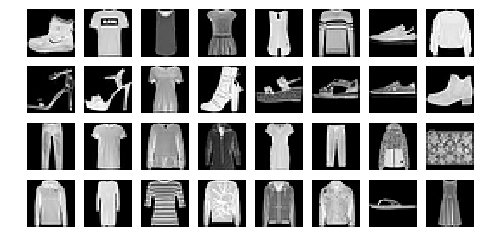

In [8]:
#Fashion-MNISTデータセット取得関数を呼ぶ

data_num = 60000 #使用したいデータ件数を記述。32以上60000以下。（本気の）訓練をさせる場合は60000件全件を推奨。

#Fashion-MNISTデータセット取得
train_data = load_dataset(data_num=data_num)
print("train_data.shape:", train_data.shape) #(data_num, 28, 28, 1)

#そのうち32件を表示
show_images(train_data[0:32])

### 訓練済モデルにFashion-MNISTの類似画像を生成させる

とりあえず、本モデルがどういった画像を生成するかお見せするために、訓練済モデルから画像を生成させます。

＜ニセモノ～訓練済モデルが生成～＞


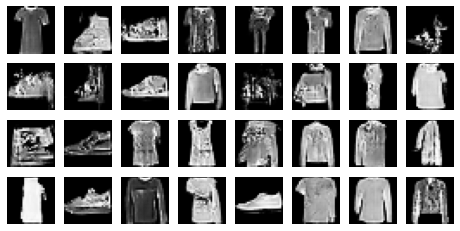


＜ホンモノ＞


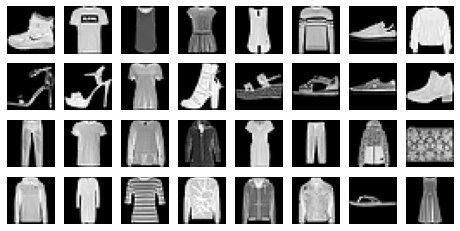

In [ ]:
#訓練済モデルを新規のモデルインスタンスに移植
#そして画像を生成させる

#まずはモデルのインスタンスを生成
gan_model_transplanted = dcgan_fmnist_kr(name="model_to_be_transplanted_into", z_dim=100, img_shape=(28, 28, 1))

#訓練済モデルをこのモデルインスタンスに移植
#移植元である「訓練済モデル」の実体はファイル3個
g_file_name = "for_demo_trained_g_2.h5" #移植元である訓練済モデル（donor）のgenerator
d_file_name = "for_demo_trained_d_2.h5" #移植元である訓練済モデル（donor）のdiscriminator
val_file_name = "for_demo_trained_val_2.pickle" #移植元である訓練済モデル（donor）のその他の変数
#生成したモデルインスタンスに訓練済モデルの3ファイルを読み込ませる
gan_model_transplanted.change_me(files_dir="./demo_model_files/", 
                                   g_file_name=g_file_name, 
                                   d_file_name=d_file_name, 
                                   val_file_name=val_file_name)
gan_model_transplanted.name = "model_transplanted"

#画像を生成するために必要な潜在変数zの生成
#生成する画像は32枚とする
z = gan_model_transplanted.generate_z(len_z=32)

#ニセモノ画像の生成
imgs_sample = gan_model_transplanted.generate(z) 

#ニセモノ画像の表示
print("＜ニセモノ～訓練済モデルが生成～＞")
show_images(imgs_sample)

#比較のため、ホンモノ画像も表示
print("\n＜ホンモノ＞")
show_images(train_data[0:32])

### モデルを訓練する

新規にモデルインスタンスを生成し、訓練用のホンモノ画像を与えて、指定したエポックだけ訓練させます。<br>
GPUの使用を強く推奨します！<BR>
※モデルは、以下のデータを訓練データとして受け付けます。<BR>
・numpy配列で、shapeは(N, H, W, C)　Kerasで言うところのdata_format='channels_last'<BR>
・画素値の値域は[0, 255]でも[0, 1]でもよい


Epoch: 0
 iteration count: 469
 g_loss_epoch: 3.905306577682495
 d_loss_epoch: 0.184071883559227
 d_accuracy_epoch: 0.9327999949455261
 Discriminatorは偽物画像1250枚を平均0.11843759の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.93697274の確率で本物と推定


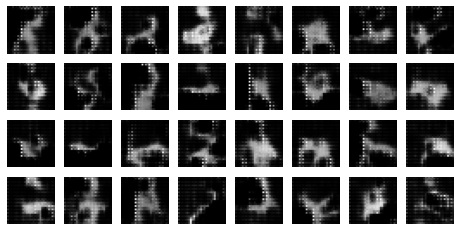

 Processing time(seconds): 34
 Time: 01:42:09

Epoch: 1
 iteration count: 938
 g_loss_epoch: 2.602189064025879
 d_loss_epoch: 0.1565255969762802
 d_accuracy_epoch: 0.9480000138282776
 Discriminatorは偽物画像1250枚を平均0.12890223の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.91355276の確率で本物と推定
 Processing time(seconds): 30
 Time: 01:42:39

Epoch: 2
 iteration count: 1407
 g_loss_epoch: 3.782381296157837
 d_loss_epoch: 0.11996789276599884
 d_accuracy_epoch: 0.9571999907493591
 Discriminatorは偽物画像1250枚を平均0.07828787の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.92310965の確率で本物と推定
 Processing time(seconds): 29
 Time: 01:43:08

Epoch: 3
 iteration count: 1876
 g_loss_epoch: 3.3078930377960205
 d_loss_epoch: 0.22450557351112366
 d_accuracy_epoch: 0.9136000275611877
 Discriminatorは偽物画像1250枚を平均0.097068824の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.84138596の確率で本物と推定
 Processing time(seconds): 30
 Time: 01:43:39

Epoch: 4
 iteration count: 2345
 g_loss_epoch: 3.515747547149658
 d_loss_epoch: 0.21562834084033966
 d_accuracy_epoc

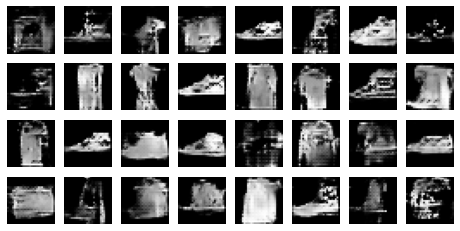

 Processing time(seconds): 32
 Time: 01:44:41

Epoch: 6
 iteration count: 3283
 g_loss_epoch: 2.122392416000366
 d_loss_epoch: 0.24431034922599792
 d_accuracy_epoch: 0.8996000289916992
 Discriminatorは偽物画像1250枚を平均0.20031527の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.87367606の確率で本物と推定
 Processing time(seconds): 29
 Time: 01:45:11

Epoch: 7
 iteration count: 3752
 g_loss_epoch: 2.559969902038574
 d_loss_epoch: 0.24596191942691803
 d_accuracy_epoch: 0.9067999720573425
 Discriminatorは偽物画像1250枚を平均0.14096053の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.81775403の確率で本物と推定
 Processing time(seconds): 29
 Time: 01:45:41

Epoch: 8
 iteration count: 4221
 g_loss_epoch: 2.3630971908569336
 d_loss_epoch: 0.2888672947883606
 d_accuracy_epoch: 0.8751999735832214
 Discriminatorは偽物画像1250枚を平均0.18217719の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.81729084の確率で本物と推定
 Processing time(seconds): 29
 Time: 01:46:10

Epoch: 9
 iteration count: 4690
 g_loss_epoch: 2.0798559188842773
 d_loss_epoch: 0.3046218156814575
 d_accuracy_epoc

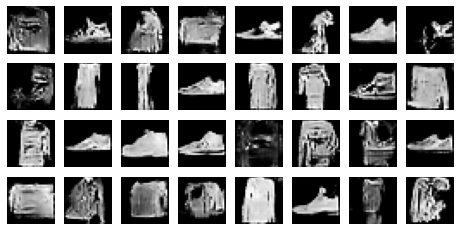

 Processing time(seconds): 32
 Time: 01:47:14

Epoch: 11
 iteration count: 5628
 g_loss_epoch: 1.9039113521575928
 d_loss_epoch: 0.3724157214164734
 d_accuracy_epoch: 0.8284000158309937
 Discriminatorは偽物画像1250枚を平均0.24453448の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.78749764の確率で本物と推定
 Processing time(seconds): 30
 Time: 01:47:45

Epoch: 12
 iteration count: 6097
 g_loss_epoch: 1.8323285579681396
 d_loss_epoch: 0.31332850456237793
 d_accuracy_epoch: 0.8651999831199646
 Discriminatorは偽物画像1250枚を平均0.24602063の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.84038484の確率で本物と推定
 Processing time(seconds): 30
 Time: 01:48:15

Epoch: 13
 iteration count: 6566
 g_loss_epoch: 1.8810374736785889
 d_loss_epoch: 0.3862926661968231
 d_accuracy_epoch: 0.8284000158309937
 Discriminatorは偽物画像1250枚を平均0.2592845の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.7935583の確率で本物と推定
 Processing time(seconds): 31
 Time: 01:48:47

Epoch: 14
 iteration count: 7035
 g_loss_epoch: 1.8474019765853882
 d_loss_epoch: 0.29650864005088806
 d_accuracy_

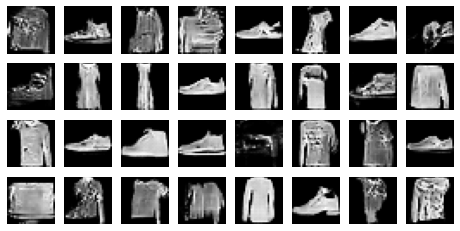

 Processing time(seconds): 34
 Time: 01:49:52

Epoch: 16
 iteration count: 7973
 g_loss_epoch: 2.111788034439087
 d_loss_epoch: 0.31070542335510254
 d_accuracy_epoch: 0.8619999885559082
 Discriminatorは偽物画像1250枚を平均0.19560722の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.7909463の確率で本物と推定
 Processing time(seconds): 32
 Time: 01:50:25

Epoch: 17
 iteration count: 8442
 g_loss_epoch: 2.1832194328308105
 d_loss_epoch: 0.30626875162124634
 d_accuracy_epoch: 0.8700000047683716
 Discriminatorは偽物画像1250枚を平均0.19608171の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.8031188の確率で本物と推定
 Processing time(seconds): 31
 Time: 01:50:57

Epoch: 18
 iteration count: 8911
 g_loss_epoch: 1.9937957525253296
 d_loss_epoch: 0.37394243478775024
 d_accuracy_epoch: 0.8271999955177307
 Discriminatorは偽物画像1250枚を平均0.22502626の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.769765の確率で本物と推定
 Processing time(seconds): 32
 Time: 01:51:29

Epoch: 19
 iteration count: 9380
 g_loss_epoch: 1.9614708423614502
 d_loss_epoch: 0.33140140771865845
 d_accuracy_e

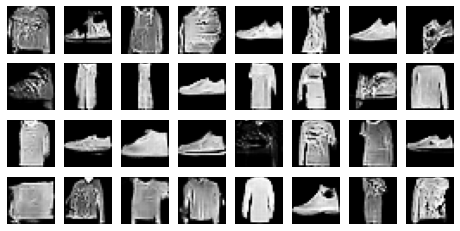

 Processing time(seconds): 35
 Time: 01:52:37

Epoch: 21
 iteration count: 10318
 g_loss_epoch: 2.090592861175537
 d_loss_epoch: 0.29243555665016174
 d_accuracy_epoch: 0.8772000074386597
 Discriminatorは偽物画像1250枚を平均0.20044036の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.8150227の確率で本物と推定
 Processing time(seconds): 32
 Time: 01:53:09

Epoch: 22
 iteration count: 10787
 g_loss_epoch: 2.542095422744751
 d_loss_epoch: 0.2704288363456726
 d_accuracy_epoch: 0.8812000155448914
 Discriminatorは偽物画像1250枚を平均0.16326982の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.8157499の確率で本物と推定
 Processing time(seconds): 31
 Time: 01:53:41

Epoch: 23
 iteration count: 11256
 g_loss_epoch: 2.0857808589935303
 d_loss_epoch: 0.29820260405540466
 d_accuracy_epoch: 0.8763999938964844
 Discriminatorは偽物画像1250枚を平均0.2090855の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.8354589の確率で本物と推定
 Processing time(seconds): 32
 Time: 01:54:13

Epoch: 24
 iteration count: 11725
 g_loss_epoch: 2.087445020675659
 d_loss_epoch: 0.3464680016040802
 d_accuracy_e

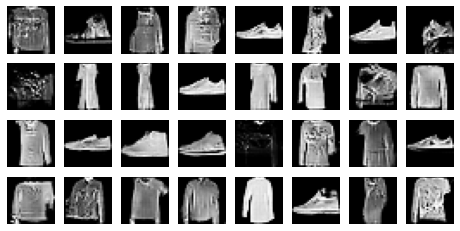

 Processing time(seconds): 33
 Time: 01:55:19

Epoch: 26
 iteration count: 12663
 g_loss_epoch: 2.5282063484191895
 d_loss_epoch: 0.2434602975845337
 d_accuracy_epoch: 0.8980000019073486
 Discriminatorは偽物画像1250枚を平均0.1449183の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.818306の確率で本物と推定
 Processing time(seconds): 31
 Time: 01:55:50

Epoch: 27
 iteration count: 13132
 g_loss_epoch: 2.0403223037719727
 d_loss_epoch: 0.31723153591156006
 d_accuracy_epoch: 0.8551999926567078
 Discriminatorは偽物画像1250枚を平均0.20734262の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.79157424の確率で本物と推定
 Processing time(seconds): 31
 Time: 01:56:21

Epoch: 28
 iteration count: 13601
 g_loss_epoch: 2.2381527423858643
 d_loss_epoch: 0.26709726452827454
 d_accuracy_epoch: 0.8871999979019165
 Discriminatorは偽物画像1250枚を平均0.20408294の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.85468817の確率で本物と推定
 Processing time(seconds): 31
 Time: 01:56:52

Epoch: 29
 iteration count: 14070
 g_loss_epoch: 2.1446526050567627
 d_loss_epoch: 0.26840299367904663
 d_accur

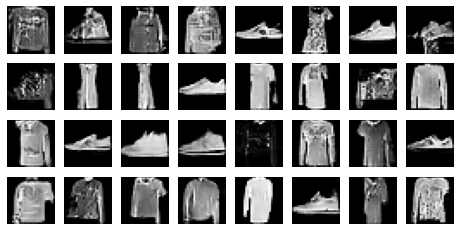

 Processing time(seconds): 33
 Time: 01:57:57

Epoch: 31
 iteration count: 15008
 g_loss_epoch: 2.2380998134613037
 d_loss_epoch: 0.2990576922893524
 d_accuracy_epoch: 0.8668000102043152
 Discriminatorは偽物画像1250枚を平均0.20599541の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.82716113の確率で本物と推定
 Processing time(seconds): 31
 Time: 01:58:29

Epoch: 32
 iteration count: 15477
 g_loss_epoch: 2.3222079277038574
 d_loss_epoch: 0.2855001389980316
 d_accuracy_epoch: 0.8820000290870667
 Discriminatorは偽物画像1250枚を平均0.18958917の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.8201328の確率で本物と推定
 Processing time(seconds): 31
 Time: 01:59:01

Epoch: 33
 iteration count: 15946
 g_loss_epoch: 2.431277275085449
 d_loss_epoch: 0.2484608143568039
 d_accuracy_epoch: 0.8907999992370605
 Discriminatorは偽物画像1250枚を平均0.17179914の確率で本物と推定
 Discriminatorは本物画像1250枚を平均0.84541094の確率で本物と推定
 Processing time(seconds): 31
 Time: 01:59:32

Epoch: 34
 iteration count: 16415
 g_loss_epoch: 2.5533969402313232
 d_loss_epoch: 0.25367704033851624
 d_accura

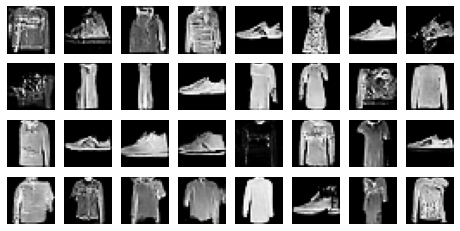

 Processing time(seconds): 34
 Time: 02:00:37

Total Processing time: 0 hours 19 minutes 3 seconds


In [ ]:
#モデルを訓練

#モデルのインスタンスを生成
gan_model_train = dcgan_fmnist_kr(name="training_20200827_03", z_dim=100, img_shape=(28, 28, 1))

#訓練
#epochs=36：36エポック訓練する、という指定。
#sample_img_interval：何エポック毎に,サンプルイメージを生成して表示するか。最初のエポックと最終エポックでも生成・表示される。
result = gan_model_train.train(train_data, epochs=36, batch_size=128, sample_img_interval=5)
#戻り値resultは、訓練時の様々な記録を保持しているDictionaryオブジェクトである。

### 今の訓練記録をグラフ表示

訓練関数train()は、訓練時の様々な記録（主にエポック毎のlossやaccuracy）を保持しているDictionaryオブジェクト「result」を返します。<br>
「result」内の記録を抽出すれば、エポック毎の推移グラフなどを描く、などができます。

モデルインスタンス「training_20200827_03」の訓練記録

<<Discriminator、Generatorのloss>>


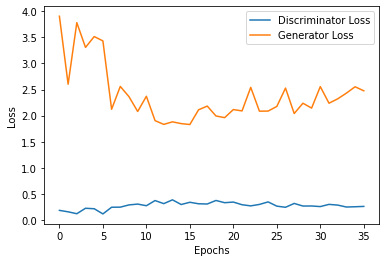

<<DiscriminatorのAccuracy>>


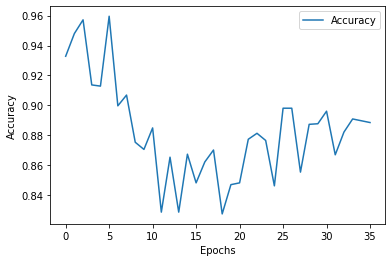

<<ホンモノ画像（real）とニセモノ画像（fake）それぞれをDiscriminatorがどのくらいの確率でホンモノと推定したか>>


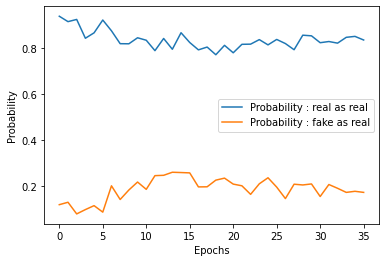

In [ ]:
#訓練関数train()は、訓練時の様々な記録を保持しているDictionaryオブジェクト「result」を返す。
#訓練時の様々な記録とは、主に、エポック毎の記録である。
#各エポック毎の記録：
#　DiscriminatorのlossとaccuracyとGeneratorのloss
#　ホンモノ画像とニセモノ画像それぞれをDiscriminatorがどのくらいの確率でホンモノと推定したか
#　処理時間
#全体の記録：全処理時間

#これらの記録を使用し、種々の情報のグラフを表示する。

name = result["name"]
print("モデルインスタンス「" + name + "」の訓練記録\n")

#Discriminator、Generatorのlossのグラフ表示

print("<<Discriminator、Generatorのloss>>")
epochs = result["epochs"]    
d_loss_epochs =  result["d_loss_epochs"]
g_loss_epochs = result["g_loss_epochs"]    
epochs_arr = np.arange(0, epochs)
plt.plot(epochs_arr, d_loss_epochs, label="Discriminator Loss")
plt.plot(epochs_arr, g_loss_epochs, label="Generator Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Discriminatorのaccuracyのグラフ表示

print("<<DiscriminatorのAccuracy>>")
epochs = result["epochs"]    
d_accuracy_epochs =  result["d_accuracy_epochs"]    
epochs_arr = np.arange(0, epochs)
plt.plot(epochs_arr, d_accuracy_epochs, label="Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

#ホンモノ画像とニセモノ画像の、Discriminatorによるホンモノ推定確率のグラフ表示

print("<<ホンモノ画像（real）とニセモノ画像（fake）それぞれをDiscriminatorがどのくらいの確率でホンモノと推定したか>>")
epochs = result["epochs"]    
probs_real_epochs =  result["probs_real_epochs"] 
probs_fake_epochs = result["probs_fake_epochs"]    
epochs_arr = np.arange(0, epochs)
plt.plot(epochs_arr, probs_real_epochs, label="Probability : real as real")
plt.plot(epochs_arr, probs_fake_epochs, label="Probability : fake as real")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Probability")
plt.show()

### 今訓練したモデルで類似画像を生成してみる

＜ニセモノ～今訓練したモデルが生成～＞


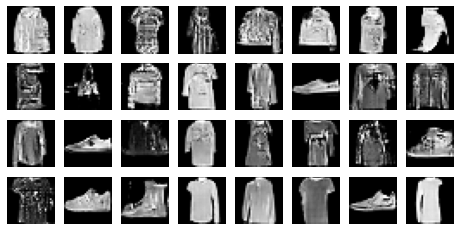


＜ホンモノ＞


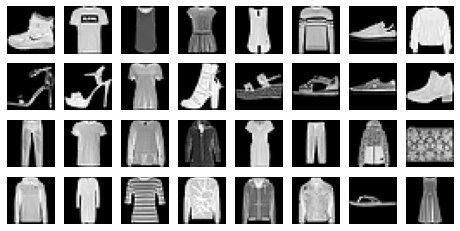

In [22]:
#今訓練したモデルでニセモノ画像を生成

#画像を生成するために必要な潜在変数zの生成
#生成する画像は32枚とする
z = gan_model_train.generate_z(len_z=32)

#ニセモノ画像の生成
imgs_sample = gan_model_train.generate(z) 

#ニセモノ画像の表示
print("＜ニセモノ～今訓練したモデルが生成～＞")
show_images(imgs_sample)

#比較のため、ホンモノ画像も表示
print("\n＜ホンモノ＞")
show_images(train_data[0:32])

### 今訓練したモデルの保存

今訓練したモデルを保存します。<br>
この機能は、訓練済（又は訓練途中）モデルを保存して再利用する、といった用途を想定しています。<br>
訓練済モデルの保存とは、3ファイル（Generator、Discriminator、その他の変数）を生成し、保存することです。<br>
この後、別のモデルインスタンスを生成し、保存した3ファイルをこのモデルインスタンスに”移植”する、ということができます（冒頭「訓練済モデルにFashion-MNISTのニセモノ画像を生成させる」はこれです）。

In [ ]:
#訓練済モデルの保存

#モデルの保存　Generator、Discriminator、その他の変数、の3ファイルを生成し、保存

#これら3ファイルを置く場所を指定する（必須）
files_dir="./hoge/" #←適宜変更

#これら3ファイルのファイル名を指定する（任意）
#指定無き時はモデルインスタンス名がファイル名に使用される（(name)_g.h5, (name)_d.h5, (name)_val.pickle）
g_file_name = "hoge_g.h5" #←適宜変更するか、引数として指定しない
d_file_name = "hoge_d.h5" #←適宜変更するか、引数として指定しない
val_file_name = "hoge_val.pickle" #←適宜変更するか、引数として指定しない

#モデルを保存
#3ファイル出力
gan_model_train.save_me(files_dir=files_dir, 
                                   g_file_name=g_file_name, 
                                   d_file_name=d_file_name, 
                                   val_file_name=val_file_name)